# Introduction

This projects aims to identify the author of the Book of Hebrews from the Bible using various Natural Language Processing methods. Currently, the author of the Book of Hebrews is unknown. The text used will be the New Testament portion of the King James Version of the Bible. After cleaning up the text and tokenizing it, the following methods will be used to identify the author of Hebrews:

1. Bag of Words (BOW)
2. N-Grams
3. Latent Dirichlet Allocation (LDA)
4. Doc2Vec
5. Long Short Term Memory (LSTM)
6. TensorFlow
7. Bidirectional Encoder Representations from Transformers (BERT)

Each model will be evaluated, with the results compared to each other as well as the current scholarly consensus on the authorship of Hebrews.

Step 1: Importing Packages

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, BertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import euclidean_distances, accuracy_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import re
import string

Most of these packages are for machine learning methods, with some for Natural Language Processing and data visualisation.

Step 2: Reading the text and tokenizing the words

In [7]:
# Reading the original KJV Bible
file1 = open('/Users/weizheng/Desktop/Data-Science-Projects/KJV_Bible/bible.rtf', encoding = "ISO-8859-1")
contents1 = file1.read()

# Tokenize the contents of the file into words
tokenized_words = nltk.word_tokenize(contents1)

# Remove the first 33 items from the tokenized_words list, which is a general disclaimer
tokenized_words = tokenized_words[33:]

# Creates a new file with remaining tokenized words of the KJV Bible
filename = '/Users/weizheng/Desktop/Data-Science-Projects/KJV_Bible/bible_tokenized_words.rtf'                
with open(filename, 'w') as file:
    for word in tokenized_words:
        file.write(word + ' ')

The original King James Version Bible is read, tokenized, and organised into files.

Step 3: Cleaning up the text and dividing the text by book

In [8]:
# Finds the beginning of each book, useful for indexing by book
def find_indeces(tokenized_words):
    return [i for i, word in enumerate(tokenized_words) if word == '1:1']

start_indeces = find_indeces(tokenized_words)

# This function tokenizes the name of the book
def tokenize_book_name(book_name):
    token_name = nltk.word_tokenize(book_name)
    return token_name

# Cleans unnecessary punctuation and random characters and items for tokenized_words
def clean_word_tokens(tokenize):
    tokenize = [word for word in tokenize if word != '\\' and not re.match(r'\d+:\d+', word)]
    tokenize = [word.rstrip('\\') for word in tokenize]
    tokenize = [re.sub(r'\\', '', word) for word in tokenize]
    tokenize = [re.sub(r'\d', '', word) for word in tokenize]
    tokenize = [re.sub(r'[^\w\s]', '', word) for word in tokenize]
    tokenize = [word for word in tokenize if word not in string.punctuation and word not in ['', ' ']]
    tokenize = [word.rstrip('.').rstrip('\\').rstrip(':').rstrip(';') for word in tokenize]
    return tokenize

# This functions cleans the tokens and returns a dictionary of tokenized words by book
def tokenized_words_by_book(key, tokenized_words, start_indices):
    bible_books_tokenized_words = {}
    for i in range(len(key)):
        if i < len(key) - 1:
            start_index = start_indices[i]
            end_index = start_indices[i+1]
            tokenize = tokenized_words[start_index: end_index]
            tokenize = clean_word_tokens(tokenize)
            key_words = tokenize_book_name(key[i+1])
            key_words = [word for word in key_words if word != ',']
            bible_books_tokenized_words[key[i]] = tokenize[:len(tokenize) - len(key_words)]
        else:
            start_index = start_indices[i]
            tokenize = tokenized_words[start_index:]
            tokenize = clean_word_tokens(tokenize)
            bible_books_tokenized_words[key[i]] = tokenize
    return bible_books_tokenized_words

new_testament_names = ['The Gospel According to Saint Matthew',
                      'The Gospel According to Saint Mark',
                      'The Gospel According to Saint Luke',
                      'The Gospel According to Saint John',
                      'The Acts of the Apostles',
                      'The Epistle of Paul the Apostle to the Romans',
                      'The First Epistle of Paul the Apostle to the Corinthians',
                      'The Second Epistle of Paul the Apostle to the Corinthians',
                      'The Epistle of Paul to the Galatians',
                      'The Epistle of Paul the Apostle to the Ephesians',
                      'The Epistle of Paul the Apostle to the Philippians',
                      'The Epistle of Paul the Apostle to the Colossians',
                      'The First Epistle of Paul the Apostle to the Thessalonians' ,
                      'The Second Epistle of Paul the Apostle to the Thessalonians',  
                      'The First Epistle of Paul the Apostle to Timothy',
                      'The Second Epistle of Paul the Apostle to Timothy',
                      'The Epistle of Paul to Titus',  
                      'The Epistle of Paul to Philemon',
                      'The Epistle of Paul the Apostle to the Hebrews',
                      'The General Epistle of James',
                      'The First Epistle General of Peter',
                      'The Second Epistle General of Peter',
                      'The First Epistle General of John',
                      'The Second Epistle General of John',
                      'The Third Epistle General of John',
                      'The General Epistle of Jude',
                      'The Revelation of St. John the Divine']

# These are dictionaries of New Testament tokenized words and tokenized sentences
new_testament_words = tokenized_words_by_book(new_testament_names, tokenized_words, start_indeces[39:])  

The original text had plenty of white space and undesirable characters and punctuation. These functions strip out the unnecessary characters and sort the tokenized words into dictionaries with the respective book as keys.

Step 4: Creating a class entitled Analyzer that lays out all the analytical methods to identify the author of the book of Hebrews

In [11]:
class Analyzer:
# Defining the initial parameters of the Analyzer class
    def __init__(self):
        self.word_tokens = new_testament_words
        self.authors = ['Matthew', 'John Mark', 'Luke', 'John',
                        'Luke', 'Paul', 'Paul', 'Paul',
                        'Paul', 'Paul', 'Paul', 'Paul',
                        'Paul', 'Paul', 'Paul', 'Paul',
                        'Paul', 'Paul', 'Unknown', 'James',
                        'Peter', 'Peter', 'John', 'John',
                        'John', 'Jude', 'John']
        self.stop_words = ['the', 'and', 'of', 'to', 'that', 'in', 'he', 'shall',
                           'unto', 'for', 'i', 'his', 'a', 'they', 'be', 'is',
                           'not', 'him', 'them', 'it', 'with', 'all', 'thou', 
                           'thy', 'was', 'which', 'my', 'me', 'said', 'but', 
                           'ye', 'their', 'have', 'will', 'thee', 'from', 'as', 
                           'are', 'when', 'this', 'out', 'were', 'upon', 'by', 
                           'you', 'up', 'there', 'hath', 'then', 'came', 'had',
                           'into', 'on', 'her', 'come', 'one', 'we', 'before',
                           'your', 'also', 'an', 'so', 'shalt', 'if', 'at', 
                           'let', 'go', 'us', 'saying', 'went', 'no', 'even', 
                           'do', 'now', 'saith', 'therefore', 'every', 'these',
                           'after', 'our', 'things', 'down', 'or', 'hast', 'o',
                           'say', 'because', 'may', 'over', 'did', 'what', 'she',
                           'who', 'thine', 'among', 'away', 'any', 'put', 
                           'thereof', 'forth', 'neither', 'am', 'pass', 
                           'according', 'should', 'whom', 'know', 'nor', 'thus',
                           'set', 'more', 'yet', 'again', 'like', 'mine', 
                           'about', 'called', 'own', 'spake', 'speak', 'done',
                           'how', 'thing', 'heard', 'off', 'given', 'answered',
                           'together', 'than', 'ever', 'gave', 'those', 'other',
                           'himself', 'take', 'took', 'made', 'day', 'against',
                           'behold', 'make', 'name', 'give', 'brought', 'bring',
                           'sent', 'see', 'saw', 'brethren', 'through', 'would',
                           'many', 'another', 'side', 'first', 'without', 'can',
                           'where', 'found', 'themselves', 'under', 'until', 
                           'midst', 'keep', 'both', 'none', 'toward', 'yea',
                           'stood', 'taken', 'same', 'been', 'whose', 'being',
                           'spoken', 'much', 'surely', 'told', 'why', 'cometh',
                           'seen', 'written', 'very', 'well', 'only', 'such', 
                           'send', 'between', 'some', 'though', 'therein', 
                           'shew', 'begat', 'nothing', 'above', 'tell', 
                           'thyself', 'while', 'part', 'gone', 'long', 'near', 
                           'doth', 'manner', 'certain', 'having', 'yourselves',
                           'lest', 'cast', 'must', 'verily', 'whosoever']
        
#   Creating a features dictionary to be used in the Bag of Words method
    def create_features_dictionary(self, words):
        features_dictionary = {}
        index = 0
        for word in words:
            if word not in features_dictionary:
                features_dictionary[word] = index
                index += 1
        return features_dictionary

#   Returns a bow vector given a set of words in reference to a sample of text
    def text_to_bow_vector(self, some_text, words):
        features_dictionary = self.create_features_dictionary(words)
        bow_vector = len(features_dictionary)*[0]
        for word in some_text:
            if word in features_dictionary:
                feature_index = features_dictionary[word]
                bow_vector[feature_index] += 1
        return bow_vector
    
#   Using the Bag of Words (BOW) method to find the author of Hebrews
    def bow_test(self):
        # Prepare the data
        word_tokens_copy = {key: value for key, value in self.word_tokens.items() if key != 'The Epistle of Paul the Apostle to the Hebrews'}
        authors_copy = [author for author in self.authors if author != 'Unknown']
        word_tokens_list = list(word_tokens_copy.values())
        words = []
        for book_words in word_tokens_list:
            words += book_words

        # Create features dictionary
        features_dictionary = self.create_features_dictionary(words)

        # Make bow vectors
        X = []
        for book_words in word_tokens_list:
            bow_vector = self.text_to_bow_vector(book_words, features_dictionary)
            X.append(bow_vector)
        X = np.array(X)

        # Perform cross-validation
        book_classifier = GaussianNB()
        scores = cross_val_score(book_classifier, X, authors_copy, cv=5)
        mean_score = scores.mean()

        # Train the model on the entire dataset
        best_model = book_classifier.fit(X, authors_copy)

        # Predict the author of the book of Hebrews
        book_of_hebrews = self.word_tokens['The Epistle of Paul the Apostle to the Hebrews']
        bow_vector = self.text_to_bow_vector(book_of_hebrews, features_dictionary)
        predicted_probabilities = best_model.predict_proba([bow_vector])[0]
        threshold = 0.5
        predicted_author = None
        max_prob = 0
        for i, prob in enumerate(predicted_probabilities):
            if prob >= threshold and prob > max_prob:
                max_prob = prob
                predicted_author = best_model.classes_[i]

        if predicted_author is None:
            predicted_author = "None of the known authors"

        # Plot the likelihood of each author being the author of Hebrews
        author_probabilities = dict(zip(best_model.classes_, predicted_probabilities))
        author_names = list(author_probabilities.keys())
        probabilities = list(author_probabilities.values())

        plt.barh(author_names, probabilities)
        plt.xlabel('Probability')
        plt.ylabel('Author')
        plt.title('Likelihood of Each Author being the Author of Hebrews')
        plt.show()

        # Return the predicted author, probabilities and accuracy
        return predicted_author, author_probabilities, mean_score
    
#   Using the N-Gram method to find the author of Hebrews
    def ngram_test(self):
        # Prepare the data
        word_tokens_copy = {key: value for key, value in self.word_tokens.items()
                            if key != 'The Epistle of Paul the Apostle to the Hebrews'}
        authors_copy = [author for author in self.authors if author != 'Unknown']
        books = list(word_tokens_copy.keys())
        corpus = [" ".join(tokens) for tokens in word_tokens_copy.values()]

        # Create an N-gram vectorizer
        vectorizer = CountVectorizer(ngram_range=(1, 5))
        X = vectorizer.fit_transform(corpus)

        # Encode the authors
        le = LabelEncoder()
        y = le.fit_transform(authors_copy)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train a Naive Bayes classifier
        clf = MultinomialNB()
        clf.fit(X_train, y_train)

        # Evaluate the classifier
        accuracy = clf.score(X_test, y_test)

        # Use the trained classifier to predict the author of the book of Hebrews
        book_of_hebrews = " ".join(self.word_tokens['The Epistle of Paul the Apostle to the Hebrews'])
        X_hebrews = vectorizer.transform([book_of_hebrews])
        
        # Calculate the probabilities of each author being the author of Hebrews
        predicted_probabilities = clf.predict_proba(X_hebrews)[0]

        # Select the author with the highest probability
        predicted_author_index = np.argmax(predicted_probabilities)
        predicted_author = le.inverse_transform([predicted_author_index])[0]

        # Plot the likelihood of each author being the author of Hebrews
        author_probabilities = dict(zip(le.classes_, predicted_probabilities))
        author_names = list(author_probabilities.keys())
        probabilities = list(author_probabilities.values())

        plt.barh(author_names, probabilities)
        plt.xlabel('Probability')
        plt.ylabel('Author')
        plt.title('Likelihood of Each Author being the Author of Hebrews')
        plt.show()

        # Return the predicted author, probabilities, and accuracy
        return predicted_author, author_probabilities, accuracy
    
#   Using the Latent Dirichlet Allocation (LDA) method to find the author of Hebrews
    def lda_test(self):
        # Prepare the data
        word_tokens_copy = {key: value for key, value in self.word_tokens.items()
                            if key != 'The Epistle of Paul the Apostle to the Hebrews'}
        authors_copy = [author for author in self.authors if author != 'Unknown']
        books = list(word_tokens_copy.keys())
        corpus = [' '.join(tokens) for tokens in word_tokens_copy.values()]

        # Vectorize the text
        vectorizer = CountVectorizer(stop_words=self.stop_words)
        X = vectorizer.fit_transform(corpus)

        # Train the LDA model
        lda = LatentDirichletAllocation(n_components=len(authors_copy), random_state=42)
        lda.fit(X)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, authors_copy, test_size=0.2, random_state=42)

        # Predict the authors
        y_pred = lda.transform(X_test).argmax(axis=1)
        y_pred = [authors_copy[i] for i in y_pred]

        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Predict the author of the book of Hebrews
        book_of_hebrews = ' '.join(self.word_tokens['The Epistle of Paul the Apostle to the Hebrews'])
        X_hebrews = vectorizer.transform([book_of_hebrews])
        predicted_probabilities = lda.transform(X_hebrews)[0]

        # Select the author with the highest probability
        predicted_author_index = predicted_probabilities.argmax()
        if predicted_probabilities[predicted_author_index] < 0.5:
            predicted_author = "Unknown"
        else:
            predicted_author = authors_copy[predicted_author_index]

        # Plot the likelihood of each author being the author of Hebrews
        author_probabilities = dict(zip(authors_copy, predicted_probabilities))
        author_names = list(author_probabilities.keys())
        probabilities = list(author_probabilities.values())

        plt.barh(author_names, probabilities)
        plt.xlabel('Probability')
        plt.ylabel('Author')
        plt.title('Likelihood of Each Author being the Author of Hebrews')
        plt.show()

        # Return the predicted author, probabilities, and accuracy
        return predicted_author, author_probabilities, accuracy

#   Using the Doc2Vec method to find the author of Hebrews
    def doc2vec_test(self):
        word_tokens_copy = {key: value for key, value in self.word_tokens.items()
                            if key != 'The Epistle of Paul the Apostle to the Hebrews'}
        authors_copy = [author for author in self.authors if author != 'Unknown']
        books = list(word_tokens_copy.keys())
        corpus = list(word_tokens_copy.values())

        # Create TaggedDocument objects for the Doc2Vec model
        tagged_documents = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(corpus)]

        # Train the Doc2Vec model
        model = Doc2Vec(tagged_documents, vector_size=100, window=5, min_count=1, workers=4, epochs=50)

        # Calculate the similarity scores
        book_of_hebrews_words = self.word_tokens["The Epistle of Paul the Apostle to the Hebrews"]
        book_of_hebrews_vector = model.infer_vector(book_of_hebrews_words)
        similarity_scores = [cosine_similarity([book_of_hebrews_vector], [model.dv[i]])[0][0] for i in range(len(corpus))]

        most_similar_book_index = np.argmax(similarity_scores)
        most_similar_book = list(self.word_tokens.keys())[most_similar_book_index]
        most_similar_book_author = authors_copy[most_similar_book_index]

        # Plot the likelihood of each author being the author of Hebrews based on Doc2Vec similarity
        author_similarities = {author: 0 for author in authors_copy}
        for book_index, author in enumerate(authors_copy):
            author_similarities[author] = max(author_similarities[author], similarity_scores[book_index])

        author_names = list(author_similarities.keys())
        similarities = list(author_similarities.values())

        plt.barh(author_names, similarities)
        plt.xlabel('Similarity')
        plt.ylabel('Author')
        plt.title('Similarity Scores of Each Author in Relation to Hebrews (Doc2Vec)')
        plt.show()

        # Return the predicted author and similarity scores
        return most_similar_book_author, author_similarities

#   Using the Long Short Term Memory method to find the author of Hebrews    
    def lstm_test(self):
        word_tokens_copy = {key: value for key, value in self.word_tokens.items()
                            if key != 'The Epistle of Paul the Apostle to the Hebrews'}
        authors_copy = [author for author in self.authors if author != 'Unknown']
        books = list(word_tokens_copy.keys())
        corpus = list(word_tokens_copy.values())

        # Create a tokenizer to map words to integers
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(corpus)
        X = tokenizer.texts_to_sequences(corpus)
        X = pad_sequences(X)

        encoded_authors = [i for i, author in enumerate(set(authors_copy))]
        author_to_index = {author: index for index, author in enumerate(set(authors_copy))}
        y = [author_to_index[author] for author in authors_copy]
        y = to_categorical(y)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Build the LSTM model
        model = Sequential()
        model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))
        model.add(LSTM(100, return_sequences=True))
        model.add(LSTM(100))
        model.add(Dense(len(set(authors_copy)), activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

        # Evaluate the model
        score, accuracy = model.evaluate(X_test, y_test, verbose=0)

        # Plot the training and validation loss
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
        
        # Plot the change in accuracy over time
        plt.plot(history.history['accuracy'], label='Training accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Time')
        plt.legend()
        plt.show()

        # Use the trained model to predict the author of the book of Hebrews
        book_of_hebrews = self.word_tokens['The Epistle of Paul the Apostle to the Hebrews']
        X_hebrews = tokenizer.texts_to_sequences([book_of_hebrews])
        X_hebrews = pad_sequences(X_hebrews, maxlen=X.shape[1])
        predictions = model.predict(X_hebrews)
        predicted_author_index = np.argmax(predictions)
        predicted_author = [key for key, value in author_to_index.items() if value == predicted_author_index][0]

        # Prepare the likelihoods of each author having written Hebrews
        author_names = list(author_to_index.keys())
        probabilities = predictions[0]
        author_likelihoods = dict(zip(author_names, probabilities))

        # Plot the likelihood of each author being the author of Hebrews
        author_names = list(author_to_index.keys())
        probabilities = predictions[0]

        plt.barh(author_names, probabilities)
        plt.xlabel('Probability')
        plt.ylabel('Author')
        plt.title('Likelihood of Each Author being the Author of Hebrews (LSTM)')
        plt.show()

        # Return the predicted author and accuracy
        return predicted_author, author_likelihoods, accuracy

#   Using the TensorFlow Method to find the author of Hebrews  
    def tensorflow_test(self):
        word_tokens_copy = {key: value for key, value in self.word_tokens.items()
                            if key != 'The Epistle of Paul the Apostle to the Hebrews'}
        authors_copy = [author for author in self.authors if author != 'Unknown']
        books = list(word_tokens_copy.keys())
        corpus = list(word_tokens_copy.values())

        # Create a tokenizer to map words to integers
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(corpus)
        X = tokenizer.texts_to_sequences(corpus)
        X = pad_sequences(X)

        # Encode the authors
        le = LabelEncoder()
        y = le.fit_transform(authors_copy)
        num_classes = len(le.classes_)

        # Create author_to_index dictionary
        author_to_index = {name: index for index, name in enumerate(le.classes_)}

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)

        # Build the model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))
        model.add(tf.keras.layers.LSTM(100, return_sequences=True))
        model.add(tf.keras.layers.LSTM(100))
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

        # Evaluate the model
        score, accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        # Plot the training and validation loss
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        # Plot the training and validation accuracy
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()

        # Use the trained model to predict the author of the book of Hebrews
        book_of_hebrews = self.word_tokens['The Epistle of Paul the Apostle to the Hebrews']
        X_hebrews = tokenizer.texts_to_sequences([book_of_hebrews])
        X_hebrews = pad_sequences(X_hebrews, maxlen=X.shape[1])
        predictions = model.predict(X_hebrews)
        predicted_author_index = np.argmax(predictions)
        predicted_author = [key for key, value in author_to_index.items() if value == predicted_author_index][0]

        # Prepare the likelihoods of each author having written Hebrews
        author_names = list(author_to_index.keys())
        probabilities = predictions[0]
        author_likelihoods = dict(zip(author_names, probabilities))
        
        # Plot the likelihood of each author being the author of Hebrews
        plt.bar(author_names, probabilities)
        plt.xlabel('Author')
        plt.ylabel('Likelihood')
        plt.title('Likelihood of Each Author Being the Author of Hebrews')
        plt.xticks(rotation=45)
        plt.show()

        # Return the predicted author, probabilities, and accuracy
        return predicted_author, author_likelihoods, accuracy
    
#   Using Hugging Face's Transformers method to find the author of Hebrews
    def transformers_test(self):
        word_tokens_copy = {key: value for key, value in self.word_tokens.items()
                            if key != 'The Epistle of Paul the Apostle to the Hebrews'}
        authors_copy = [author for author in self.authors if author != 'Unknown']
        books = list(word_tokens_copy.keys())
        corpus = list(word_tokens_copy.values())

        # Tokenize the text
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        input_ids = []
        attention_masks = []
        for text in corpus:
            text = text[0]
            encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True,
                                                max_length=512, pad_to_max_length=True,
                                                return_attention_mask=True, return_tensors='pt')
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])


        # Convert the lists of tensors to a tensor
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        # Encode the authors
        le = LabelEncoder()
        encoded_authors = torch.tensor(le.fit_transform(authors_copy))

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(input_ids, encoded_authors, test_size=0.2, random_state=42)
        train_masks, test_masks, _, _ = train_test_split(attention_masks, encoded_authors, test_size=0.2, random_state=42)

        # Convert the data to tensors
        X_train = X_train.long()
        X_test = X_test.long()
        y_train = y_train.long()
        y_test = y_test.long()
        train_masks = train_masks.long()
        test_masks = test_masks.long()

        # Define the model
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(authors_copy)))

        # Create DataLoader instances for the training and testing data
        train_dataset = TensorDataset(X_train, train_masks, y_train)
        test_dataset = TensorDataset(X_test, test_masks, y_test)
        
        train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        # Train the model
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
        model.train()

        training_loss = []
        training_accuracy = []
        for epoch in range(20):
            running_loss = 0.0
            correct = 0
            total = 0
            for i, data in enumerate(train_dataloader):
                optimizer.zero_grad()
                x_train, mask, y_train = data
                outputs = model(x_train, attention_mask=mask)
                loss = criterion(outputs.logits, y_train)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs.logits, 1)
                total += y_train.size(0)
                correct += (predicted == y_train).sum().item()
            epoch_loss = running_loss / (i + 1)
            epoch_accuracy = correct / total
            training_loss.append(epoch_loss)
            training_accuracy.append(epoch_accuracy)
            print(f'Epoch: {epoch + 1} Loss: {epoch_loss} Accuracy: {epoch_accuracy}')

        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                x_test, mask, y_test = data
                outputs = model(x_test, attention_mask=mask)
                _, predicted = torch.max(outputs.logits, 1)
                total += y_test.size(0)
                correct += (predicted == y_test).sum().item()
        accuracy = correct / total
        print(f'Accuracy: {accuracy}')
        
        # Plot the training loss and accuracy
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        ax1.plot(training_loss, label='Training Loss', color='tab:red')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')

        ax2.plot(training_accuracy, label='Training Accuracy', color='tab:blue')
        ax2.set_ylabel('Accuracy', color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        fig.tight_layout()
        plt.title('Training Loss and Accuracy')
        plt.show()

        # Use the trained model to predict the author of the book of Hebrews
        book_of_hebrews = self.word_tokens['The Epistle of Paul the Apostle to the Hebrews']

        # Create chunks of text
        chunk_size = 442
        book_of_hebrews_chunks = [' '.join(book_of_hebrews[i:i + chunk_size]) for i in range(0, len(book_of_hebrews), chunk_size)]

        # Predict the probabilities for each chunk using the model
        chunk_probs = []
        for chunk in book_of_hebrews_chunks:
            encoded_hebrews = tokenizer.encode_plus(chunk, add_special_tokens=True,
                                                    max_length=512, padding='max_length',
                                                    return_attention_mask=True, return_token_type_ids=True, return_tensors='pt')
            input_ids_hebrews = encoded_hebrews['input_ids'].long()
            attention_mask_hebrews = encoded_hebrews['attention_mask'].long()
            token_type_ids_hebrews = encoded_hebrews['token_type_ids'].long()

            with torch.no_grad():
                outputs = model(input_ids_hebrews, attention_mask=attention_mask_hebrews, token_type_ids=token_type_ids_hebrews)
                logits = outputs[0]
                chunk_probs.append(torch.softmax(logits, dim=1).squeeze(0).tolist())

        # Average the probabilities across all chunks
        avg_probs = [sum(x) / len(x) for x in zip(*chunk_probs)]

        # Get the index of the highest average probability and use it to find the predicted author
        predicted_author_index = avg_probs.index(max(avg_probs))

        # Return the predicted author, author likelihoods, and accuracy
        predicted_author = le.classes_[predicted_author_index]
        author_likelihoods = dict(zip(le.classes_, avg_probs))
        if author_likelihoods[predicted_author] < 0.5:
            predicted_author = "Unknown"
        else:
            predicted_author = authors_copy[predicted_author_index]

        # Plot the likelihood of each author being the author of Hebrews
        plt.bar(le.classes_, avg_probs)
        plt.xlabel('Author')
        plt.ylabel('Likelihood')
        plt.title('Likelihood of Each Author Being the Author of Hebrews')
        plt.xticks(rotation=45)
        plt.show()

        return predicted_author, author_likelihoods, accuracy
    
analyze = Analyzer()

The Analyzer class contains a plethora of machine learning methods to help identify the author of the Book of Hebrews. It incorporates the dictionary of tokenized words from the previous section, as well as hardcoding the names of the authors for each New Testament book. A manual list of stop-words was created by finding the most common words in the New Testament and throwing out the ones that don't contribute to the meaning of the text. This had to be done by hand as opposed to using the standard Python list of stop words, as the KJV Bible uses many words not found in present-day English. The exact workings and efficacy of each machine learning method will be discussed in their respective sections.

Step 5: Testing the BOW Method

/Users/weizheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


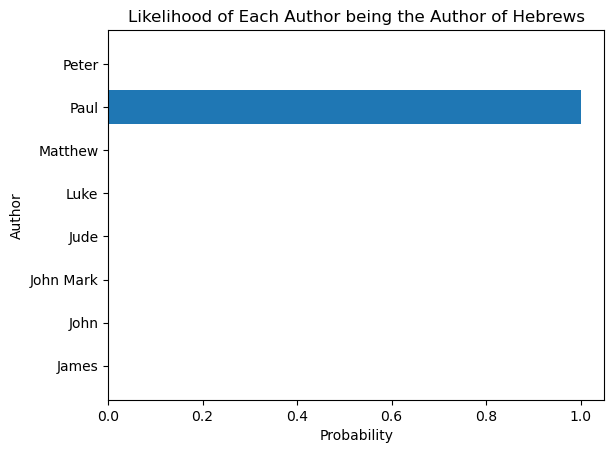

The most likely author of the Book of Hebrews using the Bag of Words method is Paul
The predicted probabilities of each author is {'James': 0.0, 'John': 0.0, 'John Mark': 0.0, 'Jude': 0.0, 'Luke': 0.0, 'Matthew': 0.0, 'Paul': 1.0, 'Peter': 0.0}
The mean score of the Bag of Words method is 0.54


In [12]:
bow_score = analyze.bow_test()
print(f"The most likely author of the Book of Hebrews using the Bag of Words method is {bow_score[0]}")
print(f"The predicted probabilities of each author is {bow_score[1]}")
print(f"The mean score of the Bag of Words method is {bow_score[2]}")

The Bag of Words (BOW) method finds the frequency of each word in a given text and stores this information in a features dictionary. The BOW method is then combined with a Gaussian Naive Bayes classifier to create and train the model to find the most likely author of the Book of Hebrews.

Originally, the BOW method used the train test split method, but this method consistently yielded accuracies of 1.0, indicating overfitting. Thus, the cross validation score method was used to evaluate the model. The mean score of 0.54 is a moderately good score, indicating some reliability in the model. The prediction using BOW is that Paul has virtually 100% chance of being the author of the Book of Hebrews.

Step 6: Testing the N-Gram Method

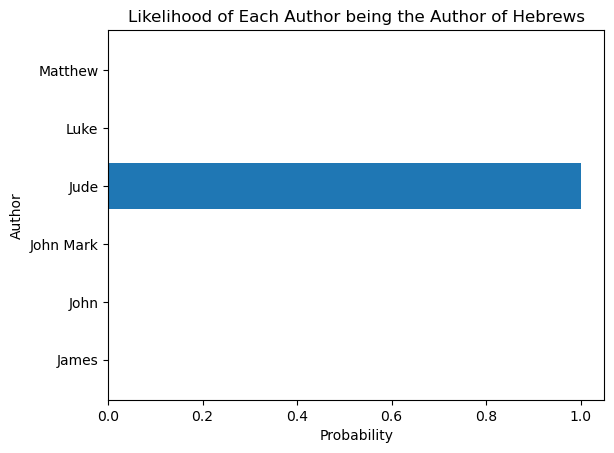

The most likely author of the Book of Hebrews using the Ngram method is Jude
The probabilities of each author is {'James': 0.0, 'John': 0.0, 'John Mark': 0.0, 'Jude': 1.0, 'Luke': 0.0, 'Matthew': 0.0}
The accuracy of the Ngram method is 0.6666666666666666


In [10]:
ngram_score = analyze.ngram_test()
print(f"The most likely author of the Book of Hebrews using the Ngram method is {ngram_score[0]}")
print(f"The probabilities of each author is {ngram_score[1]}")
print(f"The accuracy of the Ngram method is {ngram_score[2]}")

The N-Gram method creates phrases of n-length, which are then stored and used to compare the frequency of n-grams between various texts. The MultinomialNB method, a variant of the Naive Bayes Algorithm, is then used to build and train the model.

The results of the N-Gram method are disappointing. This method should be able to capture the nuances of phrases better than the BOW method. The N-Gram method predicts that Jude is the author of the Book of Hebrews. Varying the length of the n-grams didn't improve the results. Still, the accuracy of the model is 0.67, which is rather high.



Step 7: Testing the LDA Method 

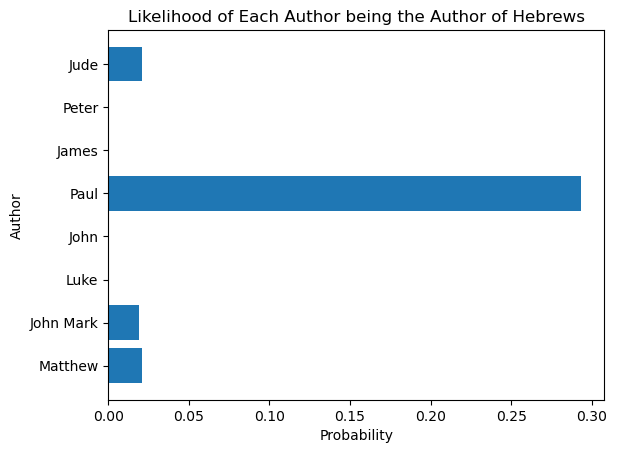

The most likely author of the Book of Hebrews using the Latent Dirichlet Allocation method is Unknown
The probabilities of each author is {'Matthew': 0.020749672492711653, 'John Mark': 0.018912224460087945, 'Luke': 1.7880771019582054e-05, 'John': 1.7880771018893155e-05, 'Paul': 0.2930300055899328, 'James': 1.7880771018893155e-05, 'Peter': 1.7880771018893155e-05, 'Jude': 0.02080935309191171}
The accuracy of the Latend Dirichlet Allocation method is 0.5


In [24]:
lda_score = analyze.lda_test()
print(f"The most likely author of the Book of Hebrews using the Latent Dirichlet Allocation method is {lda_score[0]}")
print(f"The probabilities of each author is {lda_score[1]}")
print(f"The accuracy of the Latend Dirichlet Allocation method is {lda_score[2]}")

The Latent Dirichlet Allocation method uses generative probablistic modeling to identify topics in a given text and compare them. The method assumes that each topic can be represented by a collection of words, and that each documents can be represented by a collection of topics. 

The LDA method is the first one so far that doesn't assign a certain author 100% probability of having written Hebrews. In fact, it only assigns Paul a chance of 0.29, where as other methods don't even crack 0.03. The accuracy of the LDA model is 0.5, which means its moderately good. Based on the results, the LDA method predicts that the author of Hebrews isn't any of the known authors of the New Testament.

Step 8: Testing the Doc2Vec Method

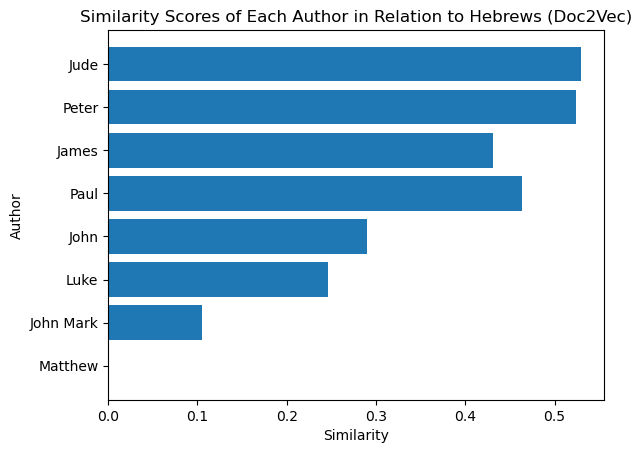

The most likely author of the Book of Hebrews using the Doc2Vec method is Jude
The similarity score of each author is {'Matthew': 0, 'John Mark': 0.10501363, 'Luke': 0.24573752, 'John': 0.28941888, 'Paul': 0.46353054, 'James': 0.4309833, 'Peter': 0.52352893, 'Jude': 0.52911586}


In [36]:
doc2vec_score = analyze.doc2vec_test()
print(f"The most likely author of the Book of Hebrews using the Doc2Vec method is {doc2vec_score[0]}")
print(f"The similarity score of each author is {doc2vec_score[1]}")

The Doc2Vec method embeds the given text in a high-dimensional vector space and tries to predict the target word with help from a sliding window of words that give context to the target word. This method excels at capturing the semantic and  syntactic meaning of the given text.

The results show that a number of authors have similar writing styles to the Book of Hebrews. Paul has a similarity score of 0.46, James is at 0.43, Peter is at 0.52, and Jude is at 0.53. As such the model is less conclusive about finding a specific candidate for the author of Hebrews. For the purposes of the project, Jude wil be selected as the author suggested by Doc2Vec. Still, the model shows that Paul, James, Peter, and Jude share much similarity in terms of topic and writing style.


Step 9: Testing the LSTM Method

Epoch 1/10
1/1 [==============================] - 112s 112s/step - loss: 2.0791 - accuracy: 0.1000 - val_loss: 2.0667 - val_accuracy: 0.6667
Epoch 2/10
1/1 [==============================] - 108s 108s/step - loss: 2.0595 - accuracy: 0.5000 - val_loss: 2.0509 - val_accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 102s 102s/step - loss: 2.0381 - accuracy: 0.5000 - val_loss: 2.0310 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 102s 102s/step - loss: 2.0113 - accuracy: 0.5000 - val_loss: 2.0035 - val_accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 101s 101s/step - loss: 1.9749 - accuracy: 0.4500 - val_loss: 1.9638 - val_accuracy: 0.6667
Epoch 6/10
1/1 [==============================] - 104s 104s/step - loss: 1.9235 - accuracy: 0.4500 - val_loss: 1.9045 - val_accuracy: 0.6667
Epoch 7/10
1/1 [==============================] - 119s 119s/step - loss: 1.8477 - accuracy: 0.4500 - val_loss: 1.8154 - val_accuracy: 0.6667
Epoch 8/10
1/

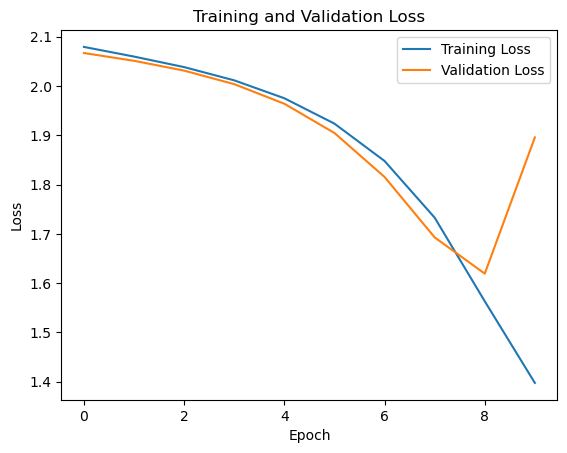

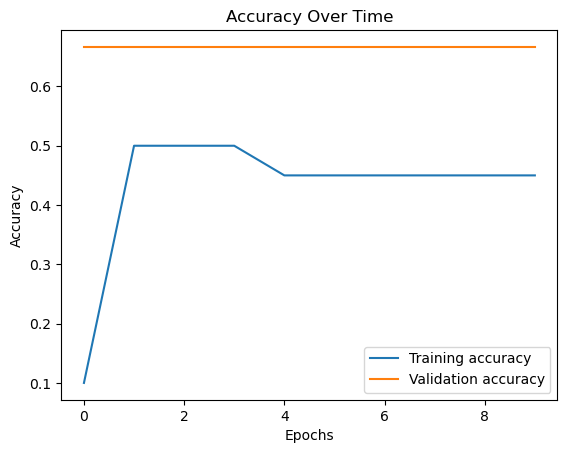

1/1 [==============================] - 3s 3s/step


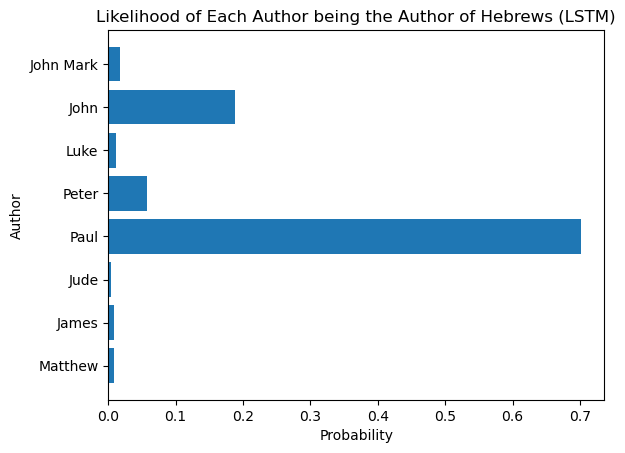

The most likely author of the Book of Hebrews using the LSTM method is Paul
The probabilities of each author is {'Matthew': 0.008635854, 'James': 0.008763939, 'Jude': 0.004670249, 'Paul': 0.70087314, 'Peter': 0.058231983, 'Luke': 0.011934237, 'John': 0.18877648, 'John Mark': 0.018114151}
The accuracy of the LSTM method is 0.6666666865348816


In [15]:
lstm_score = analyze.lstm_test()
print(f"The most likely author of the Book of Hebrews using the LSTM method is {lstm_score[0]}")
print(f"The probabilities of each author is {lstm_score[1]}")
print(f"The accuracy of the LSTM method is {lstm_score[2]}")

The Long Short Term Memory (LSTM) method uses Recurrent Neural Networks (RNN) to store information for long periods of time during the machine learning process. There are three gates: input gate that decides which information to store in the memory cells, forget gate decides which information to throw out, and the output gate which decides which information to output. Using the backpropagation through time (BPTT) algorithm, the LSTM updates its weights based on the prediction error to minimise this error. LSTM's are well-suited for text classification, such as this project.

The loss, which measures the difference between the predicted output and true output, is minimised over the training epochs, while accuracy quickly plateaus after a few epochs. Paul has a 0.70 probability of being the author of Hebrews, with the model at 0.67 accuracy. 

Step 10: Testing the TensorFlow Method

Epoch 1/10
1/1 [==============================] - 108s 108s/step - loss: 2.0778 - accuracy: 0.2000 - val_loss: 2.0586 - val_accuracy: 0.6667
Epoch 2/10
1/1 [==============================] - 101s 101s/step - loss: 2.0589 - accuracy: 0.5000 - val_loss: 2.0336 - val_accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 111s 111s/step - loss: 2.0375 - accuracy: 0.5000 - val_loss: 2.0007 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 103s 103s/step - loss: 2.0103 - accuracy: 0.4500 - val_loss: 1.9539 - val_accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 104s 104s/step - loss: 1.9728 - accuracy: 0.4500 - val_loss: 1.8842 - val_accuracy: 0.6667
Epoch 6/10
1/1 [==============================] - 110s 110s/step - loss: 1.9189 - accuracy: 0.4500 - val_loss: 1.7755 - val_accuracy: 0.6667
Epoch 7/10
1/1 [==============================] - 100s 100s/step - loss: 1.8384 - accuracy: 0.4500 - val_loss: 1.6001 - val_accuracy: 0.6667
Epoch 8/10
1/

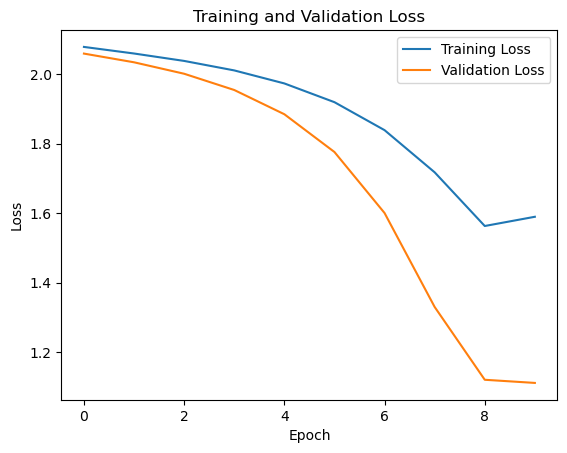

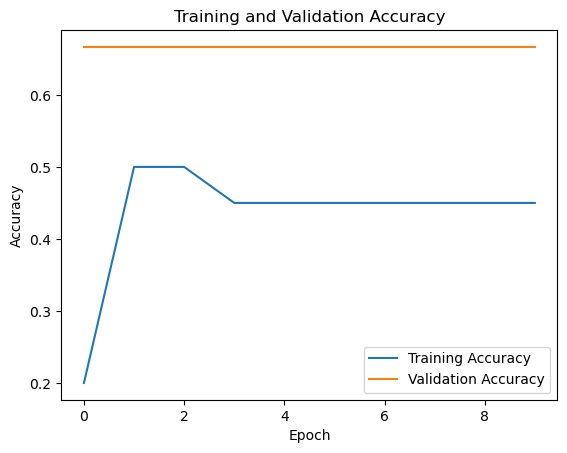

1/1 [==============================] - 3s 3s/step


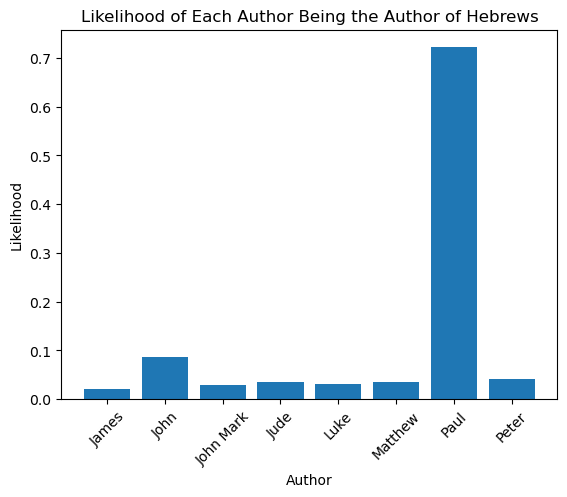

The most likely author of the Book of Hebrews using the TF method is Paul
The probabilities of each author is {'James': 0.02101391, 'John': 0.08652334, 'John Mark': 0.029091991, 'Jude': 0.03515234, 'Luke': 0.030552762, 'Matthew': 0.03481931, 'Paul': 0.7219662, 'Peter': 0.04088008}
The accuracy of the TF method is 0.6666666865348816


In [5]:
tensorflow_score = analyze.tensorflow_test()
print(f"The most likely author of the Book of Hebrews using the TF method is {tensorflow_score[0]}")
print(f"The probabilities of each author is {tensorflow_score[1]}")
print(f"The accuracy of the TF method is {tensorflow_score[2]}")

The TensowFlow method arranges the data into nodes and edges, with nodes representing various mathematical operations and edges representing the flow of data between nodes. The data itself is represented as tensors, which are multidimensional arrays. The model aims to minimise the loss.

The model identifies Paul as the most likely candidate for the author of Hebrews. His chance is 0.72, with the model being about 0.67 accurate. The loss was greatly minimised over the course of training.


Step 11: Testing the Hugging Face's Transformers Method

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/weizheng/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when init

Epoch: 1 Loss: 2.303281784057617 Accuracy: 0.0
Epoch: 2 Loss: 2.14362633228302 Accuracy: 0.05
Epoch: 3 Loss: 2.1423909664154053 Accuracy: 0.05
Epoch: 4 Loss: 2.0862526893615723 Accuracy: 0.05
Epoch: 5 Loss: 2.0426656007766724 Accuracy: 0.1
Epoch: 6 Loss: 1.990232765674591 Accuracy: 0.2
Epoch: 7 Loss: 1.8776662945747375 Accuracy: 0.5
Epoch: 8 Loss: 1.8291999697685242 Accuracy: 0.55
Epoch: 9 Loss: 1.5964629650115967 Accuracy: 0.7
Epoch: 10 Loss: 1.4594610929489136 Accuracy: 0.75
Epoch: 11 Loss: 1.4954331517219543 Accuracy: 0.7
Epoch: 12 Loss: 1.4010553359985352 Accuracy: 0.7
Epoch: 13 Loss: 1.1531232595443726 Accuracy: 0.7
Epoch: 14 Loss: 1.1328697800636292 Accuracy: 0.85
Epoch: 15 Loss: 1.0648659467697144 Accuracy: 0.75
Epoch: 16 Loss: 0.8957265019416809 Accuracy: 0.9
Epoch: 17 Loss: 0.9088775813579559 Accuracy: 0.85
Epoch: 18 Loss: 0.7622371912002563 Accuracy: 0.9
Epoch: 19 Loss: 0.7838963568210602 Accuracy: 0.85
Epoch: 20 Loss: 0.674916073679924 Accuracy: 0.85
Accuracy: 0.666666666666

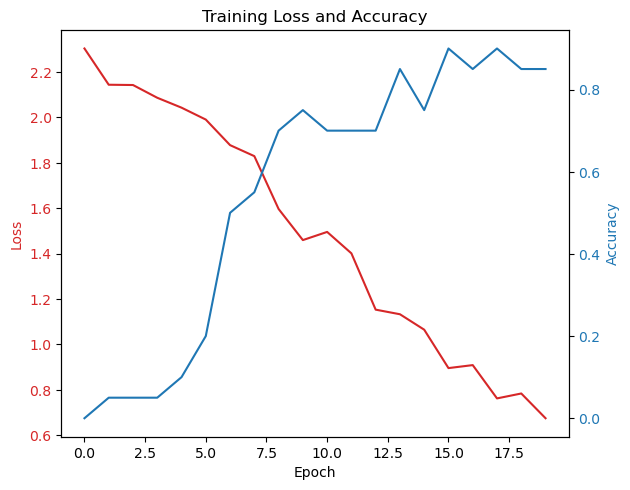

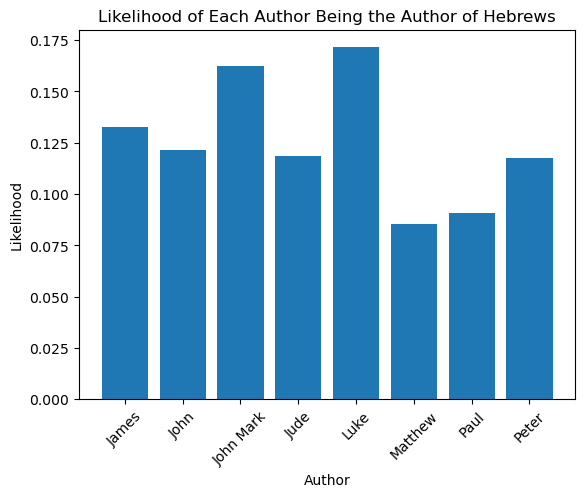

The most likely author of the Book of Hebrews using the Transformers method is Unknown
The probabilities of each author is {'James': 0.13271460449323058, 'John': 0.12150324136018753, 'John Mark': 0.16227932833135128, 'Jude': 0.11836446356028318, 'Luke': 0.17155942879617214, 'Matthew': 0.08530789380893111, 'Paul': 0.09073763620108366, 'Peter': 0.11753341602161527}
The accuracy of the Transformers method is 0.6666666666666666


In [12]:
transformers_score = analyze.transformers_test()
print(f"The most likely author of the Book of Hebrews using the Transformers method is {transformers_score[0]}")
print(f"The probabilities of each author is {transformers_score[1]}")
print(f"The accuracy of the Transformers method is {transformers_score[2]}")

The Hugging Face Transformers method uses BERT (Bidirectional Encoder Representations from Transformers), a pre-trained model developed by Google in 2018. After tokenization, BERT represents each input token as token embeddings, segment imbeddings, and position embeddings. This helps BERT better understand the position of words and sentences in the given text. The model uses the transformers method and thus has layers which alters the weights and clarifies context in the given text.

As BERT can only handle chunks of 512 tokens at a time, the Book of Hebrews has to be cut up into chunks of 442 tokens, which is the maximum number of word tokens that BERT can process given its 512 limit. In theory, the tokens can be sentences instead of individual words. However, the run time for processing sentences is far too long. The most likely candidate suggest by BERT is Luke at 0.18 probability. Since this is less than 0.5 chance, the Hugging Face Transformers method predicts that the author of Hebrews is unknown. 

# Discussion

The results of the models are as follow:

1. BOW:        Paul with a 1.0 chance
2. N-Gram:     Jude with a 1.0 chance
3. LDA:        Unknown with a 0.65 chance
4. Doc2Vec:    Jude with a 0.53 chance
5. LSTM:       Paul with a 0.70 chance
6. TensorFlow: Paul with a 0.72 chance
7. BERT:       Unknown (no candidate garnered greater than 0.5 chance)

BOW and N-Gram are both relatively simple models. As such, they have a high degree of certainty in their predictions. Bag of Words focuses on individual words, while n-grams also capture entire phrases. LDA and Doc2Vec are more complex models in that they are better equipped to understand the context of the text. LSTM is further advanced in that it has the ability to remember and adapt its strategy. However, TensorFlow and BERT are both transformer models, which allows for the encoding and decoding of data, which greatly enhances their capabilities.

The current consensus amongst biblical scholars is that the authorship of Hebrews is in doubt. However, it must be noted that for many centuries, it was believed that Paul was the author of Hebrews. Even now, Paul is regarded as one of the most likely candidates for writing Hebrews. Although much of the style is similar to Paul's writing, the book could be an imitation of Paul's writing, leaving the authorship in doubt. The models used leaves a similarly mixed result, with only 3 of the models identifying Paul as the author, 2 suggesting that the author is unknown, and the remaining 2 suggesting that Jude is the author.

# Conclusion

This project has shown both the promises and limitations of NLP. The authorship of the Book of Hebrews is a great way to put various NLP methods to the test, as the authorship is truly unknown and unlikely to be figured out given that there were many contemporaries of Paul who were familiar with his work. Although NLP methods are great at isolating key words, sentences, and even topics, all while framing them in the larger context, it doesn't have access to academic scholarship in the same way that theologians do. 

That said, NLP is still able to identify various trends than might be difficult to pick out using traditional methods. The models do show that the Book of Hebrews does have many characters of Paul's writing, but not to the point where it can be conclusively proven that Paul wrote Hebrews. NLP can be utilised in other types of research, such as sentiment analysis and generative text. For the purposes of this project, NLP has proven to be research in categorising text with certain unknown attributes, as well as testing existing scholarly beliefs on the authorship of Hebrews.